In [ ]:
!pip install ipynb


In [ ]:
# Imports
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ipynb.fs.defs.problem1 import estimate_capm



## Load in Fama French Portfolio Data

# Read the file, skipping header text rows and limiting to monthly data
ff = pd.read_csv("F-F_Research_Data_Factors 3.CSV", skiprows=3, nrows=1182)

# Rename the date column for clarity
ff.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert Date to string to extract Year and Month
ff['Date'] = ff['Date'].astype(str)
ff['Year'] = ff['Date'].str[:4].astype(int)
ff['Month'] = ff['Date'].str[4:].astype(int)

# Pull the columns we want
ff = ff[['Year', 'Month', 'Mkt-RF', 'RF']]

# Show the updated DataFrame
print(ff.head())

   Year  Month  Mkt-RF    RF
0  1926      7    2.96  0.22
1  1926      8    2.64  0.25
2  1926      9    0.36  0.23
3  1926     10   -3.24  0.32
4  1926     11    2.53  0.31


In [ ]:
# Compute market return
ff["Mkt"] = ff["Mkt-RF"] + ff["RF"]

# Compute average monthly return, volatility, and Sharpe ratio
mp_avg_return = ff["Mkt"].mean()
mp_volatility = ff["Mkt"].std()
mp_avg_excess_return = ff["Mkt-RF"].mean()
mp_sharpe_ratio = mp_avg_excess_return / mp_volatility

print(f"MP Average Monthly Return: {mp_avg_return:.4f}")
print(f"MP Volatility: {mp_volatility:.4f}")
print(f"MP Sharpe Ratio: {mp_sharpe_ratio:.4f}")

MP Average Monthly Return: 0.9557
MP Volatility: 5.3169
MP Sharpe Ratio: 0.1291


In [ ]:
# Read the file
ss = pd.read_csv("ps1_strategies.csv")

# Convert Date to string to extract Year and Month
ss['date'] = ss['date'].astype(str)
ss['Year'] = ss['date'].str[:4].astype(int)
ss['Month'] = ss['date'].str[4:].astype(int)

# Pull the columns we want
ss = ss[['Year', 'Month', 'LBHA', 'LSA', 'TA', 'HV', 'LV', 'NA', 'LB', 'HB']]

# Show the updated DataFrame
print(ss.head())

   Year  Month      LBHA     LSA        TA        HV        LV        NA  \
0  1990      1  1.498262 -7.4575  1.679061 -7.271919  0.022091 -5.392944   
1  1990      2  3.642659  1.0545  0.205289 -0.986167  0.062055 -1.768405   
2  1990      3  1.737180  1.7385 -1.572688 -0.018665  0.341639 -0.333926   
3  1990      4  0.734520 -3.1920  2.474704 -3.294381  0.253568 -2.578905   
4  1990      5  1.298923  7.9990  0.754379  8.038877 -0.113650  1.337511   

         LB         HB  
0 -1.353457 -22.772632  
1 -2.118514   5.151408  
2  1.452434   4.480134  
3  2.123740 -10.101798  
4 -1.555230  26.259080  


In [ ]:
# Merge on Year and Month
merged = pd.merge(ss, ff, on=['Year', 'Month'], how='inner')

# Check merged result
print(merged.head())

   Year  Month      LBHA     LSA        TA        HV        LV        NA  \
0  1990      1  1.498262 -7.4575  1.679061 -7.271919  0.022091 -5.392944   
1  1990      2  3.642659  1.0545  0.205289 -0.986167  0.062055 -1.768405   
2  1990      3  1.737180  1.7385 -1.572688 -0.018665  0.341639 -0.333926   
3  1990      4  0.734520 -3.1920  2.474704 -3.294381  0.253568 -2.578905   
4  1990      5  1.298923  7.9990  0.754379  8.038877 -0.113650  1.337511   

         LB         HB  Mkt-RF    RF   Mkt  
0 -1.353457 -22.772632   -7.85  0.57 -7.28  
1 -2.118514   5.151408    1.11  0.57  1.68  
2  1.452434   4.480134    1.83  0.64  2.47  
3  2.123740 -10.101798   -3.36  0.69 -2.67  
4 -1.555230  26.259080    8.42  0.68  9.10  


In [ ]:
def estimate_capm(y):
    """
    Estimates CAPM alpha and beta for a given portfolio.

    Parameters:
        y : [pd.Series] The excess returns of the asset or strategy (i.e.,
                        asset return minus risk-free rate).

    Returns:
        dict: Contains alpha, beta, and regression summary.
    """
    # Set up regression: Excess_Portfolio ~ Market Excess Return (Mkt-RF)
    X = merged['Mkt-RF']

    X = sm.add_constant(X)  # Add intercept for alpha
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params['Mkt-RF']

    return {
        'alpha': alpha,
        'beta': beta,
        'summary': model.summary(),
    }

Problem 2

In [ ]:
def analyze_strategy(strategy_name):
    """
    Analyze a strategy's performance using CAPM metrics and cumulative returns.

    Parameters:
    -----------
    strategy_name : str
        The name of the strategy column in the 'merged' DataFrame (e.g., "CA",
        "LBHA").

    Returns:
    --------
    None. Prints results and plots cumulative returns.
    """
    # Calculate total return by adding back RF
    merged[f'{strategy_name}_TR'] = merged[strategy_name] + merged['RF']

    # Basic stats
    avg_return = merged[f'{strategy_name}_TR'].mean()
    volatility = merged[f'{strategy_name}_TR'].std()
    excess_mean = merged[strategy_name].mean()
    sharpe_ratio = excess_mean / volatility

    print(f"{strategy_name} Average Monthly Return: {avg_return:.4f}")
    print(f"{strategy_name} Volatility: {volatility:.4f}")
    print(f"{strategy_name} Sharpe Ratio: {sharpe_ratio:.4f}")

    # Run CAPM regression
    X = sm.add_constant(merged['Mkt-RF'])
    y = merged[strategy_name]
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params['Mkt-RF']

    print(f"{strategy_name} Alpha: {alpha:.4f}")
    print(f"{strategy_name} Beta: {beta:.4f}")
    print(model.summary())

    # CAPM implied return
    merged[f'{strategy_name}_TR_hat'] = merged['RF'] + beta * merged['Mkt-RF']

    # Cumulative return calculations (convert % to decimals)
    merged['Mkt_cum'] = (1 + merged['Mkt'] / 100).cumprod()
    merged[f'{strategy_name}_cum'] = (1 + merged[f'{strategy_name}_TR'] /
                                      100).cumprod()
    merged[f'{strategy_name}_hat_cum'] = (1 + merged[f'{strategy_name}_TR_hat']
                                          / 100).cumprod()

    # Create datetime column
    merged['Date'] = pd.to_datetime(
        merged['Year'].astype(str) + merged['Month'].astype(str).str.zfill(2),
        format='%Y%m'
    )

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(merged['Date'], merged['Mkt_cum'], label='Market Return')
    plt.plot(merged['Date'], merged[f'{strategy_name}_cum'], label=
             f'Strategy Return ({strategy_name})')
    plt.plot(merged['Date'], merged[f'{strategy_name}_hat_cum'],
             label='Model-Implied Strategy Return (CAPM)', linestyle='--')

    plt.title(f'Cumulative Returns: Market vs {strategy_name} vs CAPM-Implied')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Growth of $1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Part (a)

LBHA Average Monthly Return: 0.6944
LBHA Volatility: 2.1102
LBHA Sharpe Ratio: 0.2303
LBHA Alpha: 0.4828
LBHA Beta: 0.0045
                            OLS Regression Results                            
Dep. Variable:                   LBHA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03677
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.848
Time:                        05:55:22   Log-Likelihood:                -854.63
No. Observations:                 397   AIC:                             1713.
Df Residuals:                     395   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

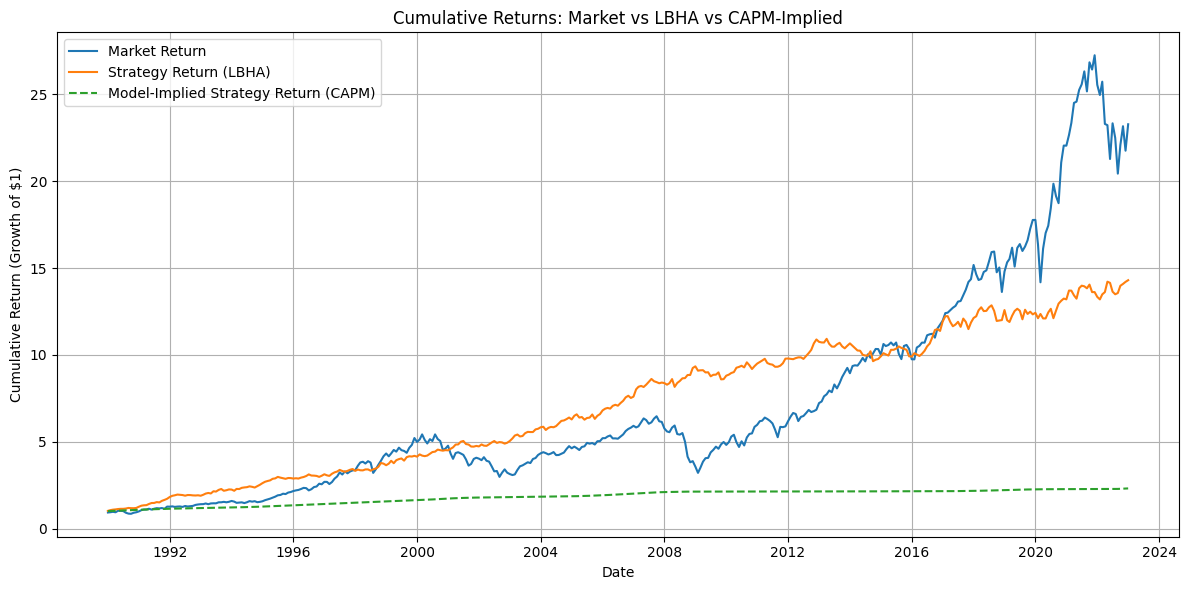

In [ ]:
analyze_strategy("LBHA")

The LBHA strategy’s metrics indicate that it produces a substantial, statistically significant alpha while taking on essentially zero market exposure (beta ≈ 0.00). Its average monthly return is 0.6944 with a volatility of 2.1102, yielding a Sharpe ratio of 0.2303. From the CAPM regression, the alpha is 0.4828 (p < 0.001), implying that even after controlling for its negligible beta (0.0045), the strategy persists in generating excess returns. Because the beta is so close to zero, this performance appears largely uncorrelated with the broader market, suggesting that the LBHA strategy **beats the market** on a risk-adjusted basis.

Part (b)

LSA Average Monthly Return: 0.9571
LSA Volatility: 3.1668
LSA Sharpe Ratio: 0.2364
LSA Alpha: 0.4794
LSA Beta: 0.3915
                            OLS Regression Results                            
Dep. Variable:                    LSA   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     171.7
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           8.09e-33
Time:                        05:57:41   Log-Likelihood:                -949.51
No. Observations:                 397   AIC:                             1903.
Df Residuals:                     395   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

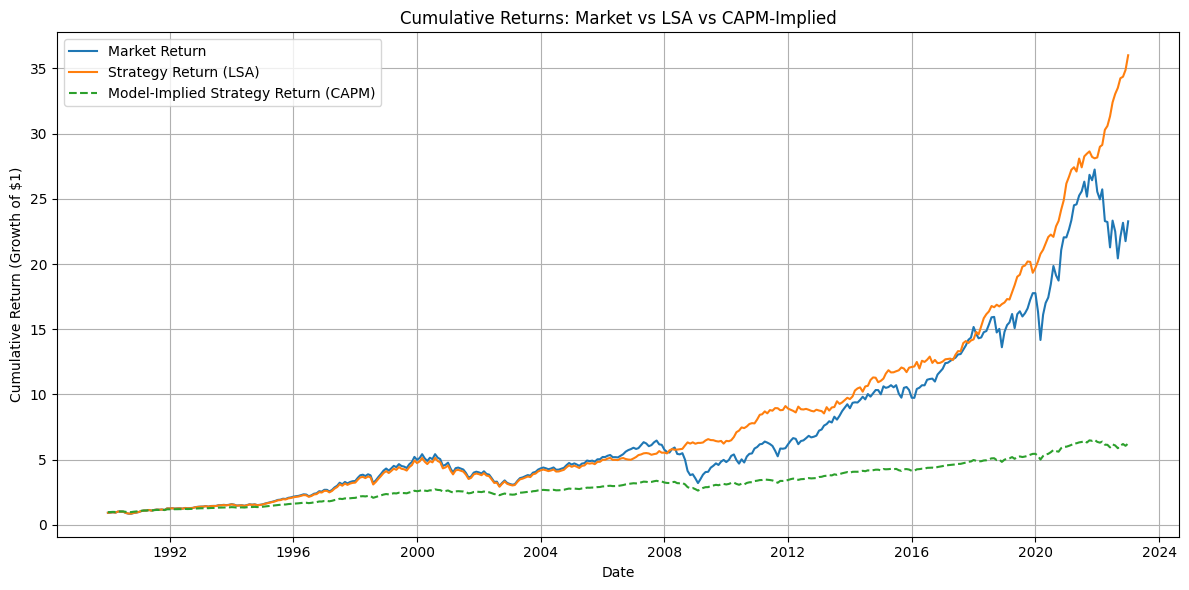

In [ ]:
analyze_strategy("LSA")

The LSA strategy demonstrates a strong, statistically significant alpha of 0.4794, indicating that even after factoring in its moderate market exposure (beta ≈ 0.39), it manages to deliver excess returns. Its average monthly return of 0.9571 and Sharpe ratio of 0.2364 further support its positive performance profile. That said, the term “late start alpha” implies that the strategy might have a shorter or more recent track record, which can make clients skeptical about the durability of its alpha. One way to mitigate these concerns is to provide robust evidence—for example, out-of-sample tests, subperiod analysis, or a clear economic rationale showing why the alpha should persist. This helps ensure the strategy’s outperformance is not the result of an isolated market phase or mere data-mining.

Part (c)

TA Average Monthly Return: 0.9612
TA Volatility: 3.4561
TA Sharpe Ratio: 0.2178
TA Alpha: 0.4036
TA Beta: 0.5078
                            OLS Regression Results                            
Dep. Variable:                     TA   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     296.8
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           5.28e-50
Time:                        05:58:48   Log-Likelihood:                -944.03
No. Observations:                 397   AIC:                             1892.
Df Residuals:                     395   BIC:                             1900.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

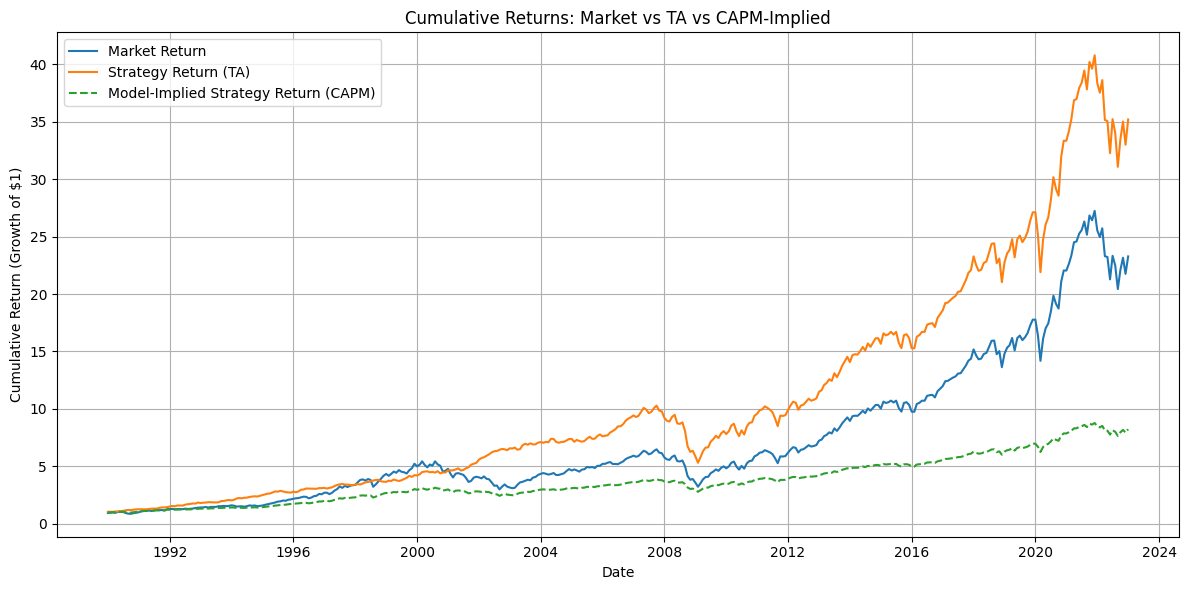

In [ ]:
analyze_strategy("TA")

The TA strategy does indeed exhibit a positive and statistically significant alpha (0.4036 with a p-value well below 0.05), meaning it outperforms what its moderate market exposure (beta of about 0.51) would predict. Its monthly return of 0.9612 and Sharpe ratio of 0.2178 suggest a respectable performance profile, although the “tapering” label may indicate that this excess return could diminish over time. Investors will be interested in TA’s current outperformance but might require additional evidence—such as subperiod analysis or economic reasoning—to be confident that the alpha remains robust in the face of changing market conditions.

Part (d)

HV Average Monthly Return: 0.9218
HV Volatility: 3.8352
HV Sharpe Ratio: 0.1860
HV Alpha: 0.1557
HV Beta: 0.8110
                            OLS Regression Results                            
Dep. Variable:                     HV   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     3163.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          1.23e-190
Time:                        05:59:02   Log-Likelihood:                -660.20
No. Observations:                 397   AIC:                             1324.
Df Residuals:                     395   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

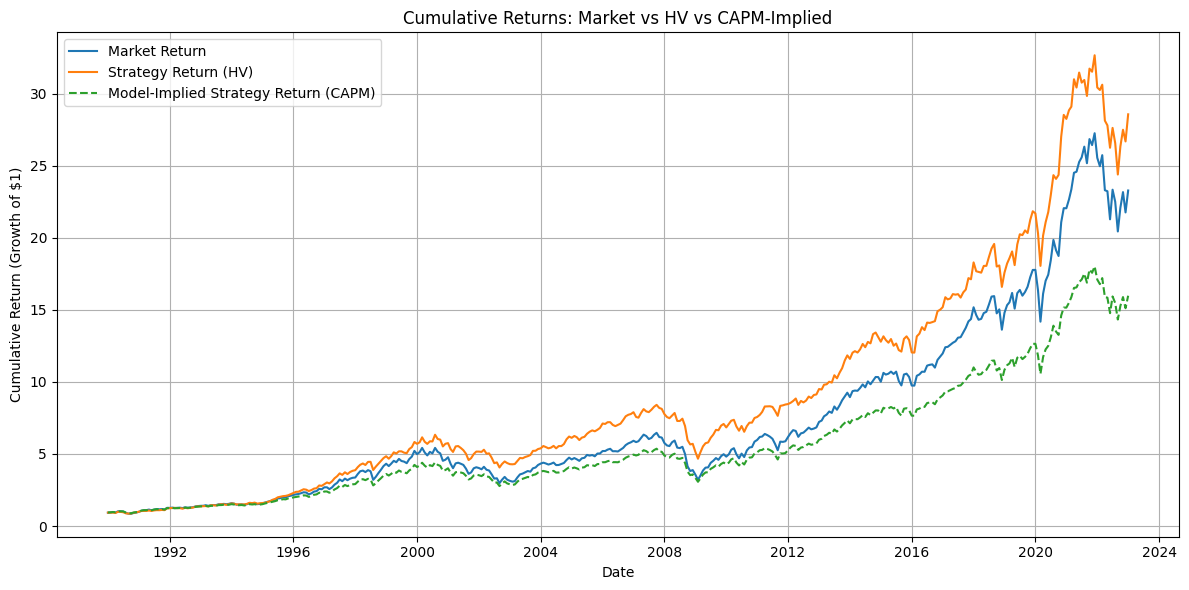

In [ ]:
analyze_strategy("HV")

LV Average Monthly Return: 0.3067
LV Volatility: 0.2147
LV Sharpe Ratio: 0.4576
LV Alpha: 0.0987
LV Beta: -0.0006
                            OLS Regression Results                            
Dep. Variable:                     LV   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3484
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.555
Time:                        05:59:05   Log-Likelihood:                 374.23
No. Observations:                 397   AIC:                            -744.5
Df Residuals:                     395   BIC:                            -736.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

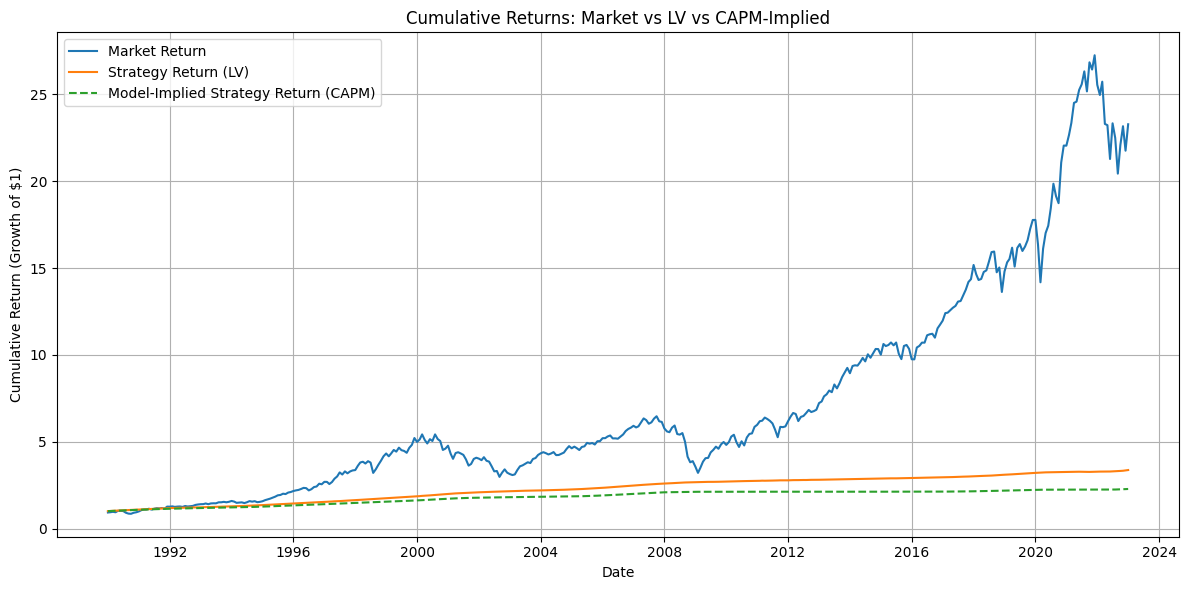

In [ ]:
analyze_strategy("LV")

From a risk‐adjusted standpoint, the low-volatility (LV) strategy may be more appealing for clients who prioritize stability and smoother returns. Although LV offers more modest absolute returns (0.3067% per month) than the high-volatility (HV) strategy (0.9218%), it compensates by dramatically reducing risk (0.2147 volatility vs. 3.8352) and maintaining a higher Sharpe ratio (0.4576 vs. 0.1860). Its near‐zero beta (–0.0006) also means the LV strategy is largely uncorrelated with broad market movements, helping investors diversify away from market risk. So while HV may look attractive on a headline‐return basis, many clients seeking a calmer ride, better consistency, and stronger risk-adjusted performance will ultimately favor LV.

Part (e)

NA Average Monthly Return: 0.1558
NA Volatility: 2.6908
NA Sharpe Ratio: -0.0196
NA Alpha: -0.4047
NA Beta: 0.5120
                            OLS Regression Results                            
Dep. Variable:                     NA   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1002.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.11e-110
Time:                        05:59:27   Log-Likelihood:                -705.75
No. Observations:                 397   AIC:                             1415.
Df Residuals:                     395   BIC:                             1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

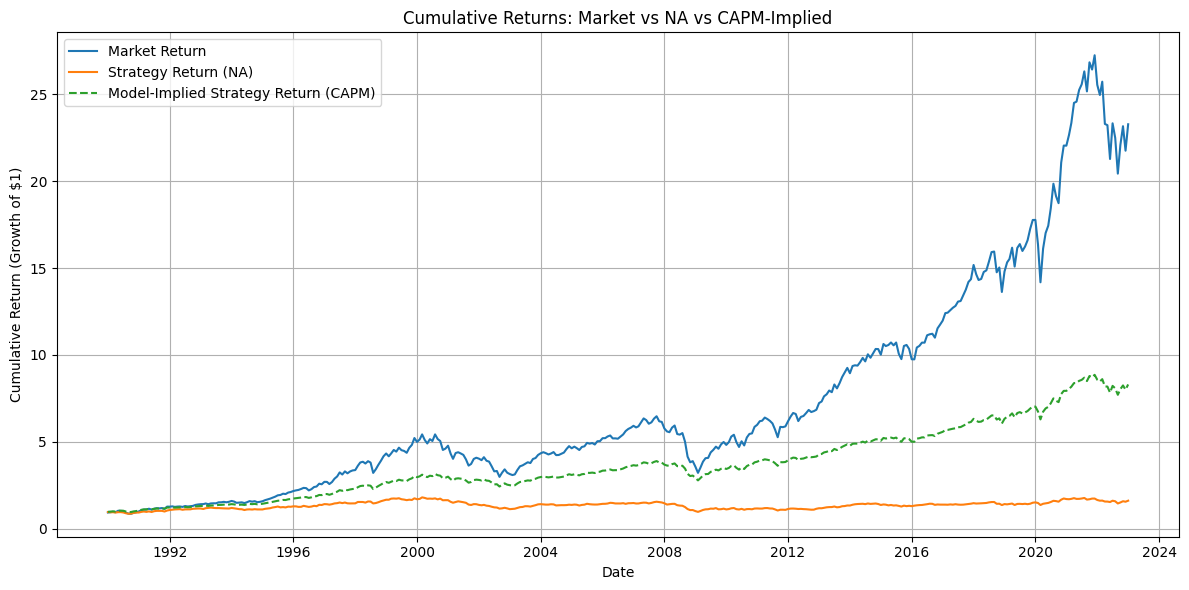

In [ ]:
analyze_strategy("NA")

Although the “negative alpha” (NA) strategy clearly underperforms relative to its moderate market exposure—its alpha is -0.4047 and statistically significant—this does not necessarily render it useless. Some investors may find value in a reliably underperforming strategy by shorting it, effectively turning that negative alpha into a potential source of gains. Alternatively, NA might serve as a hedge if its returns are negatively correlated with other portfolio components, helping to reduce overall portfolio volatility. In short, a negative alpha indicates poor standalone performance, but through creative positioning (e.g., short exposure) or thoughtful integration within a broader portfolio, even a negative-alpha strategy can play a valuable role. Therefore, NA can be **useful**.

Part (f)

LB Average Monthly Return: 0.6758
LB Volatility: 1.9407
LB Sharpe Ratio: 0.2408
LB Alpha: 0.4529
LB Beta: 0.0209
                            OLS Regression Results                            
Dep. Variable:                     LB   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9273
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.336
Time:                        06:00:26   Log-Likelihood:                -822.72
No. Observations:                 397   AIC:                             1649.
Df Residuals:                     395   BIC:                             1657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

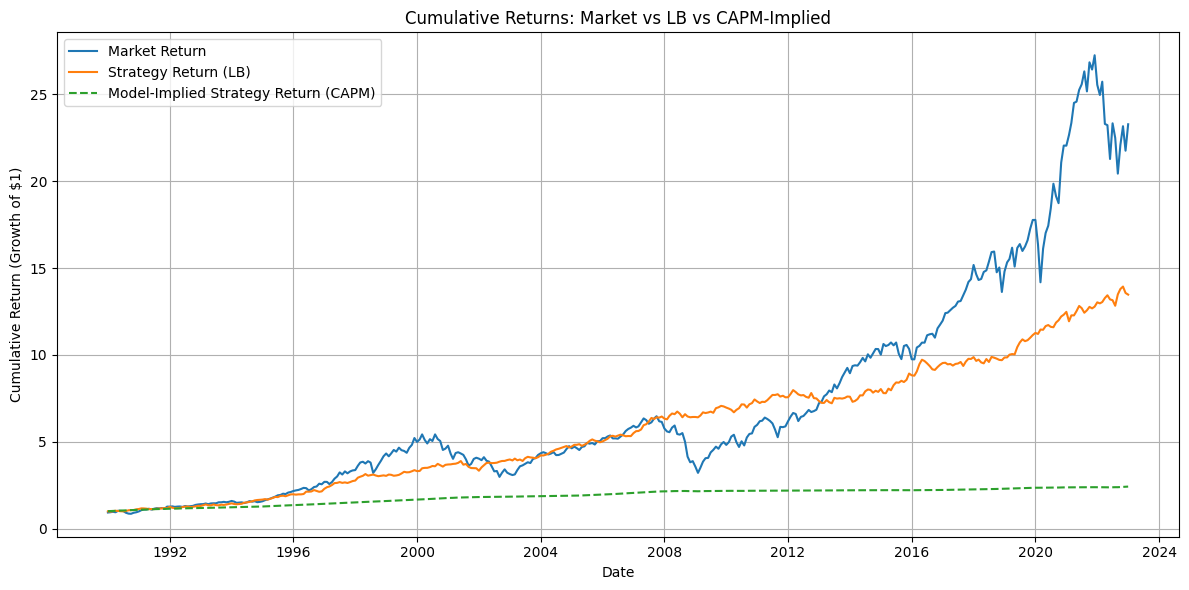

In [ ]:
analyze_strategy("LB")

HB Average Monthly Return: 2.6418
HB Volatility: 13.3758
HB Sharpe Ratio: 0.1819
HB Alpha: 0.3722
HB Beta: 2.9978
                            OLS Regression Results                            
Dep. Variable:                     HB   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.593e+05
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:00:29   Log-Likelihood:                -401.20
No. Observations:                 397   AIC:                             806.4
Df Residuals:                     395   BIC:                             814.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

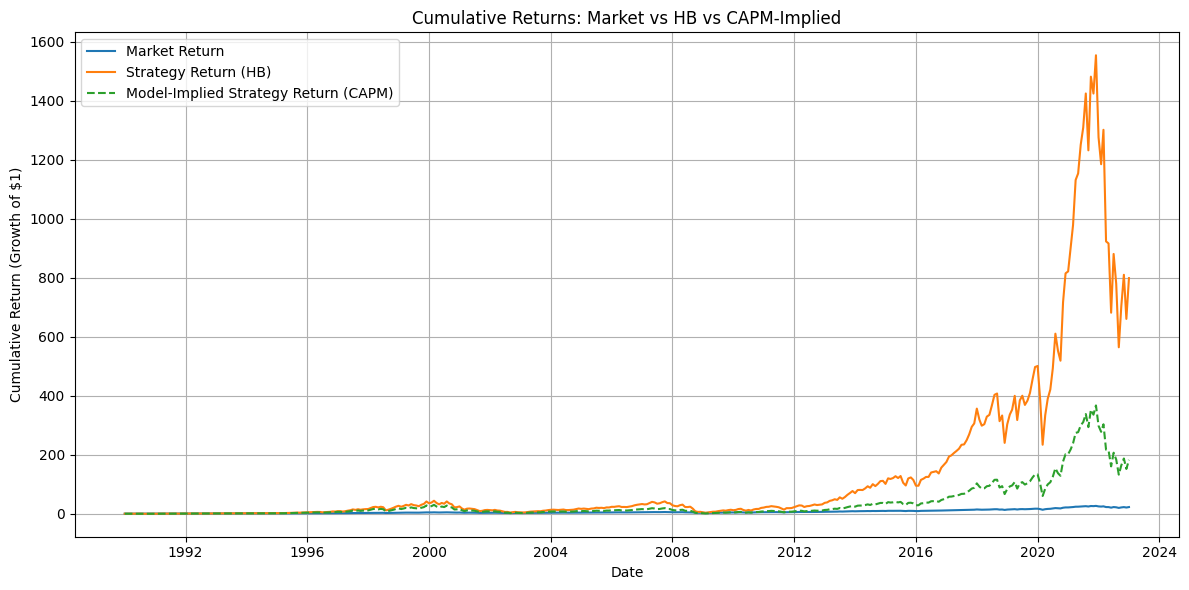

In [ ]:
analyze_strategy("HB")

From a risk-adjusted perspective, the low-beta (LB) strategy is more attractive because it delivers a higher Sharpe ratio (0.24 vs. 0.18) while also posting a larger alpha (0.45 vs. 0.37) despite having virtually no exposure to the market (beta ≈ 0.02). The LB strategy’s lower volatility (1.94 vs. 13.38) means investors can expect more consistent performance without relying heavily on broad market swings, making it an excellent choice for those who prioritize stable returns. Essentially, LB captures meaningful excess returns without imposing the significant drawdown risk and emotional stress typically associated with the far more volatile high-beta (HB) approach.